In [1]:
from andreiNet.neural_net import NeuralNetwork
from andreiNet.utils import norm_data, one_hot_encode

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
boston = datasets.load_boston()

X = boston.data  
y = boston.target

#Choose Features \
feature_idxs = [0, 1, 2, 3] # SET FEATURES BY INDEX <------------------

#feature_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
#xlbl, ylbl = feature_names[feature_idxs[0]], feature_names[feature_idxs[1]] 
# We will also split the dataset into training and testing so we can evaluate the kNN classifier
X_trn_, X_test_, y_trn, y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.5, 
                                                 random_state=2)
X_trn, X_test = X_trn_[:, feature_idxs], X_test_[:, feature_idxs]

print("X_trn.shape = {}, X_test.shape = {}".format(X_trn.shape, X_test.shape))
X_trn_norm, (trn_mean, trn_std) = norm_data(X_trn)
X_test_norm = (X_test - trn_mean) / trn_std

X_trn.shape = (253, 4), X_test.shape = (253, 4)


In [4]:
# Train model
activation = 'ReLU'
batch_size = 50
random_state = 0
lr = 0.001
n_epochs = 1000
loss = 'MSE'
metrics = []
weight_init = 'he_norm'
hidden_layers = (100, )


start_time = time.time()
nn = NeuralNetwork(hidden=hidden_layers, 
                   init_weights=weight_init,
                   loss = loss,
                   activation=activation,
                   shuffle=True,
                   random_state=random_state,
                   metrics=metrics,
                   verbose=False,
                   mode='regression'
                   )
nn.train(X_trn_norm, y_trn, 
         n_epochs=n_epochs,
         batch_size=batch_size, 
         early_stop=None, #('accuracy', 100),
         lr=lr, 
         val_data=(X_test_norm, y_test),
         save_best=False)
y_pred_trn = nn.predict(X_trn_norm).argmax(axis=1)
y_pred_test = nn.predict(X_test_norm).argmax(axis=1)
delta_1 = time.time() - start_time
print("--- %s seconds ---" % (delta_1))
print('trn MSE', mean_squared_error(y_pred_trn, y_trn))
print('test MSE', mean_squared_error(y_pred_test, y_test))

epoch 1000: final trn loss = 33.37281087558969 trn metrics {'MSE': 33.37281087558969}
val metrics {'MSE': 68.69008495529388}
--- 1.9929285049438477 seconds ---
trn MSE 542.44209486166
test MSE 641.8517391304348


In [6]:
# Train Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(random_state)
start_time = time.time()

model = Sequential()
model.add(Dense(100, activation=activation.lower(), 
                input_dim=X_trn_norm.shape[1], 
                kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear',))

sgd = SGD(lr=lr, decay=0.0, momentum=0.00, nesterov=False)

model.compile(loss='MSE',
              optimizer=sgd,
              metrics=[])

keras_hist = model.fit(X_trn_norm, y_trn,
                       epochs=n_epochs,
                       validation_data=(X_test_norm, y_test),
                       batch_size=batch_size,
                       verbose=0)
y_pred_trn = model.predict(X_trn_norm).argmax(axis=1)
y_pred_test = model.predict(X_test_norm).argmax(axis=1)
delta_2 = time.time() - start_time
print("--- %s seconds ---" % (delta_2))
print('trn acc', mean_squared_error(y_pred_trn, y_trn))
print('test acc', mean_squared_error(y_pred_test, y_test))

Using TensorFlow backend.


--- 7.3780059814453125 seconds ---
trn acc 542.44209486166
test acc 641.8517391304348


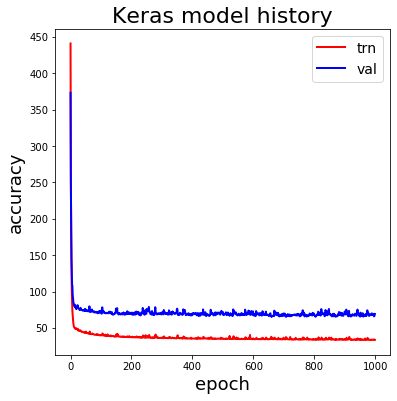

In [7]:
# Keras training history
fig_size = (6, 6)
x_axis = np.arange(n_epochs)
plt.figure(figsize=fig_size)

plt.plot(x_axis, keras_hist.history['loss'], 
         c='r', linewidth=2, label='trn')
plt.plot(x_axis, keras_hist.history['val_loss'], 
         c='b', linewidth=2, label='val')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(prop={'size': 14})

plt.title('Keras model history', fontsize=22)
plt.show()

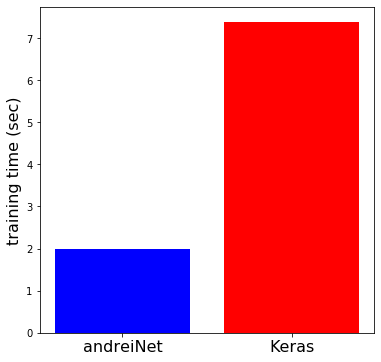

In [8]:
# compare training time
plt.figure(figsize=(6, 6))
trn_times = [delta_1, delta_2]
y_pos = [0, 1]
plt.bar(y_pos, trn_times, color=['blue', 'red'])
plt.xticks(y_pos, ['andreiNet', 'Keras'], fontsize=16) 
plt.ylabel('training time (sec)', fontsize=16)
plt.show()